Following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [14]:
import time
import scipy
import torch
import random
from torch import nn, optim, device, utils
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
from matplotlib import pyplot as plt
import torchvision as tv

device = device('cuda:0')
print(device)

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cuda:0
Random Seed:  999


In [2]:
class Generator(nn.Module):
    def __init__(self, input_dim, features_dim, output_channels):
        super(Generator, self).__init__()
        nz = input_dim
        nf = features_dim
        nc = output_channels
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, nf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nf*8, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(nf*4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(nf*2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(nf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.net(input)
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
            
class Discriminator(nn.Module):
    def __init__(self, input_channels, features_dim):
        super(Discriminator, self).__init__()
        nc = input_channels
        nf = features_dim
        self.net = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nf, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, nf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [4]:
G = Generator(input_dim=z_dim, features_dim=ngf, output_channels=nc).to(device)
D = Discriminator(input_channels=nc, features_dim=ndf).to(device)

In [5]:
criterion = nn.BCELoss()
lr = 0.0002
beta = 0.5
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta, 0.999))

In [7]:
batch_size = 128
dataroot = '/raid/artem/tmp/celeba/'
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.ImageFolder(root=dataroot, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8)
print("Batch count: ", len(dataloader))

Batch count:  1583


In [8]:
epochs = 10
G_losses = []
D_losses = []
G.apply(G.weights_init)
D.apply(D.weights_init)

for epoch in range(1, epochs+1):
    #start.record()
    start = time.time()
        
    for idx, (x, _) in enumerate(dataloader):
        #if idx == 20: break
        if x.shape[0] != batch_size: break
        
        D.zero_grad()
        
        x_real = Variable(x).to(device)
        y_real = Variable(torch.ones(batch_size,).to(device))
        D_real_loss = criterion(D(x_real).view(-1), y_real)
        D_real_loss.backward()
        
        z = Variable(torch.randn(batch_size, z_dim, 1, 1).to(device))
        y_fake = Variable(torch.zeros(batch_size).to(device))
        D_fake_loss = criterion(D(G(z)).view(-1), y_fake)
        D_fake_loss.backward()
        
        optimizerD.step()
        D_losses.append(D_real_loss + D_fake_loss)
        
        G.zero_grad()
        z = Variable(torch.randn(batch_size, z_dim, 1, 1).to(device))
        y = Variable(torch.ones(batch_size).to(device))
        
        G_loss = criterion(D(G(z)).view(-1), y)
        G_loss.backward()
        optimizerG.step()
        G_losses.append(G_loss)
        
        if not (idx % 500):
            print('[%d/%d;%d/%d]: loss_d: %.3f, loss_g: %.3f'
              % (idx, len(dataloader),
                 (epoch), epochs, 
                 torch.mean(torch.FloatTensor(D_losses)), 
                 torch.mean(torch.FloatTensor(G_losses))))
    print("Time:", time.time() - start)

[0/1583;1/10]: loss_d: 1.863, loss_g: 5.433
[500/1583;1/10]: loss_d: 0.632, loss_g: 7.615
[1000/1583;1/10]: loss_d: 0.627, loss_g: 6.264
[1500/1583;1/10]: loss_d: 0.642, loss_g: 5.575
Time: 540.2708704471588
[0/1583;2/10]: loss_d: 0.642, loss_g: 5.486
[500/1583;2/10]: loss_d: 0.644, loss_g: 5.053
[1000/1583;2/10]: loss_d: 0.646, loss_g: 4.719
[1500/1583;2/10]: loss_d: 0.651, loss_g: 4.451
Time: 540.3117144107819
[0/1583;3/10]: loss_d: 0.654, loss_g: 4.409
[500/1583;3/10]: loss_d: 0.663, loss_g: 4.176
[1000/1583;3/10]: loss_d: 0.671, loss_g: 3.981
[1500/1583;3/10]: loss_d: 0.682, loss_g: 3.823
Time: 540.4494256973267
[0/1583;4/10]: loss_d: 0.682, loss_g: 3.799
[500/1583;4/10]: loss_d: 0.692, loss_g: 3.667
[1000/1583;4/10]: loss_d: 0.699, loss_g: 3.552
[1500/1583;4/10]: loss_d: 0.704, loss_g: 3.455
Time: 537.3580536842346
[0/1583;5/10]: loss_d: 0.704, loss_g: 3.439
[500/1583;5/10]: loss_d: 0.708, loss_g: 3.360
[1000/1583;5/10]: loss_d: 0.713, loss_g: 3.290
[1500/1583;5/10]: loss_d: 0.716

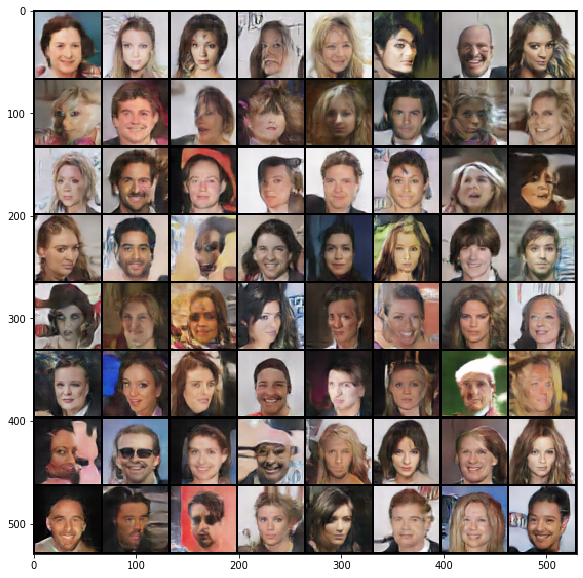

In [15]:
z = torch.randn(batch_size, z_dim, 1, 1).to(device)
x = G(z)
plt.figure(figsize=(10,10))
plt.imshow(tv.utils.make_grid(x.detach().cpu()[:64], nrow=8, normalize=True).permute(1, 2, 0))
plt.show()